# Métodos GPU: Distribuciones Estacionarias con RTX 5060

Este notebook implementa **ambos métodos** para calcular distribuciones estacionarias de cadenas de Markov usando **exclusivamente GPU** con optimizaciones CuPy.

**Métodos implementados**:
- **Método 1**: Vectores propios optimizado (πP = π)
- **Método 2**: Tiempo medio de retorno optimizado (πᵢ = 1/E[Tᵢ])

**GPU**: RTX 5060 con CUDA 13.0  
**Framework**: CuPy con optimizaciones de memoria

**Análisis de tiempos**: Variando **n** (tamaño de la cadena) y **p** (probabilidad de transición)

**Resultados guardados**: Dos archivos CSV separados para análisis posterior.

In [7]:
import sys
import os
sys.path.append(os.path.join(os.path.dirname('__file__'), '..'))

from src.markov_matrix import (
    crear_matriz_probabilidad,
    calcular_distribucion_metodo_autovalores_gpu,
    calcular_distribucion_metodo_tiempo_retorno_gpu,
    GPU_AVAILABLE,
    get_gpu_info,
    clear_gpu_memory,
    optimal_gpu_method
)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Verificar disponibilidad de GPU
print(f"🔍 Estado de GPU: {GPU_AVAILABLE}")

if not GPU_AVAILABLE:
    print("❌ ERROR: GPU no disponible")
    print("💡 Este notebook requiere GPU funcionando")
    print("💡 Ejecute: source ~/.bashrc y reinicie kernel")
    raise RuntimeError("GPU requerida pero no disponible")

# Mostrar información de GPU
gpu_info = get_gpu_info()
print(f"✅ GPU: {gpu_info['name']}")
print(f"📊 Memoria: {gpu_info['total_memory_mb']} MB")
print(f"🔧 Compute Capability: {gpu_info['compute_capability']}")
print(f"🚀 CUDA Version: {gpu_info['cuda_version']}")

# Limpiar memoria GPU al inicio
clear_gpu_memory()
print(f"🧹 Memoria GPU limpiada")

🔍 Estado de GPU: True
✅ GPU: NVIDIA GeForce RTX 5060 Laptop GPU
📊 Memoria: 8150 MB
🔧 Compute Capability: 12.0
🚀 CUDA Version: 13000
🧹 Memoria GPU limpiada


## Configuración del Análisis: Variando n y p

In [8]:
# Configuración idéntica a los notebooks método existentes
max_n = 400
fixed_interval_p = 0.1

# Crear grids para n y p
grid_n = np.arange(1, max_n)          # n: 1, 2, 3, ..., 999
grid_p = np.arange(0.1, 1, fixed_interval_p)  # p: 0.1, 0.2, 0.3, ..., 0.9

print(f"📊 Configuración del análisis:")
print(f"• Valores de n: {len(grid_n)} valores (1 a {max_n-1})")
print(f"• Valores de p: {len(grid_p)} valores ({grid_p[0]:.1f} a {grid_p[-1]:.1f})")
print(f"• Total combinaciones: {len(grid_n)} × {len(grid_p)} = {len(grid_n) * len(grid_p):,}")
print(f"• Tiempo estimado por método: ~{len(grid_n) * len(grid_p) / 1000:.0f} minutos")
print(f"• Tiempo total estimado: ~{(len(grid_n) * len(grid_p) / 1000) * 2:.0f} minutos (2 métodos)")

# Mostrar valores de p
print(f"\n🎯 Valores de p: {[f'{p:.1f}' for p in grid_p]}")
print(f"🎯 Rango de n: 1 → {max_n-1}")
print(f"\n🔧 Métodos a ejecutar:")
print(f"• Método 1: Vectores propios GPU")
print(f"• Método 2: Tiempo medio de retorno GPU")

📊 Configuración del análisis:
• Valores de n: 399 valores (1 a 399)
• Valores de p: 9 valores (0.1 a 0.9)
• Total combinaciones: 399 × 9 = 3,591
• Tiempo estimado por método: ~4 minutos
• Tiempo total estimado: ~7 minutos (2 métodos)

🎯 Valores de p: ['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9']
🎯 Rango de n: 1 → 399

🔧 Métodos a ejecutar:
• Método 1: Vectores propios GPU
• Método 2: Tiempo medio de retorno GPU


## Ejecución del Análisis GPU - Ambos Métodos

## Guardar Matrices de Tiempos en CSV - Archivos Separados

In [ ]:
# Crear matrices para almacenar los tiempos de ambos métodos
# Filas: valores de p, Columnas: valores de n
matriz_tiempos_metodo1 = np.zeros((len(grid_p), len(grid_n)))
matriz_tiempos_metodo2 = np.zeros((len(grid_p), len(grid_n)))

print(f"🚀 Iniciando análisis GPU con ambos métodos...")
print(f"Fecha/hora: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

start_time_total = time.time()
total_combinaciones = len(grid_p) * len(grid_n)

# ===============================================
# MÉTODO 1: VECTORES PROPIOS GPU
# ===============================================
print(f"\n🔬 MÉTODO 1: Vectores propios GPU")
print(f"=" * 50)

start_time_m1 = time.time()
combinacion_actual = 0

for i, p in enumerate(grid_p):
    print(f"\n📈 Procesando p = {p:.1f} ({i+1}/{len(grid_p)}) - Método 1...")
    
    for j, n in enumerate(grid_n):
        combinacion_actual += 1
        
        # Mostrar progreso cada 1000 combinaciones
        if combinacion_actual % 1000 == 0:
            progreso = (combinacion_actual / total_combinaciones) * 100
            tiempo_transcurrido = time.time() - start_time_m1
            tiempo_estimado = (tiempo_transcurrido / combinacion_actual) * (total_combinaciones - combinacion_actual)
            print(f"  [{progreso:5.1f}%] n={n:3d} | Transcurrido: {tiempo_transcurrido/60:.1f}min | ETA: {tiempo_estimado/60:.1f}min")
        
        try:
            # Crear matriz de transición
            matriz = crear_matriz_probabilidad(n, p)
            
            # Medir tiempo Método 1 GPU
            start_gpu = time.time()
            pi = calcular_distribucion_metodo_autovalores_gpu(matriz)
            tiempo_gpu = time.time() - start_gpu
            
            # Guardar en la matriz del Método 1
            matriz_tiempos_metodo1[i, j] = tiempo_gpu
            
        except Exception as e:
            print(f"    ⚠️ Error Método 1 en n={n}, p={p:.1f}: {str(e)[:50]}")
            matriz_tiempos_metodo1[i, j] = np.nan
        
        # Limpiar memoria GPU cada 100 iteraciones
        if combinacion_actual % 100 == 0:
            clear_gpu_memory()

tiempo_metodo1 = time.time() - start_time_m1
print(f"\n✅ Método 1 completado en {tiempo_metodo1/60:.1f} minutos")

# ===============================================
# MÉTODO 2: TIEMPO MEDIO DE RETORNO GPU
# ===============================================
print(f"\n🔬 MÉTODO 2: Tiempo medio de retorno GPU")
print(f"=" * 50)

start_time_m2 = time.time()
combinacion_actual = 0

for i, p in enumerate(grid_p):
    print(f"\n📈 Procesando p = {p:.1f} ({i+1}/{len(grid_p)}) - Método 2...")
    
    for j, n in enumerate(grid_n):
        combinacion_actual += 1
        
        # Mostrar progreso cada 1000 combinaciones
        if combinacion_actual % 1000 == 0:
            progreso = (combinacion_actual / total_combinaciones) * 100
            tiempo_transcurrido = time.time() - start_time_m2
            tiempo_estimado = (tiempo_transcurrido / combinacion_actual) * (total_combinaciones - combinacion_actual)
            print(f"  [{progreso:5.1f}%] n={n:3d} | Transcurrido: {tiempo_transcurrido/60:.1f}min | ETA: {tiempo_estimado/60:.1f}min")
        
        try:
            # Crear matriz de transición (reutilizar)
            matriz = crear_matriz_probabilidad(n, p)
            
            # Medir tiempo Método 2 GPU
            start_gpu = time.time()
            pi = calcular_distribucion_metodo_tiempo_retorno_gpu(matriz)
            tiempo_gpu = time.time() - start_gpu
            
            # Guardar en la matriz del Método 2
            matriz_tiempos_metodo2[i, j] = tiempo_gpu
            
        except Exception as e:
            print(f"    ⚠️ Error Método 2 en n={n}, p={p:.1f}: {str(e)[:50]}")
            matriz_tiempos_metodo2[i, j] = np.nan
        
        # Limpiar memoria GPU cada 100 iteraciones
        if combinacion_actual % 100 == 0:
            clear_gpu_memory()

tiempo_metodo2 = time.time() - start_time_m2
tiempo_total = time.time() - start_time_total

print(f"\n✅ Método 2 completado en {tiempo_metodo2/60:.1f} minutos")
print(f"\n🎉 ANÁLISIS COMPLETO en {tiempo_total/60:.1f} minutos")
print(f"📊 Total combinaciones procesadas: {total_combinaciones:,} × 2 métodos = {total_combinaciones * 2:,}")

# Convertir a DataFrames
df_tiempos_metodo1 = pd.DataFrame(matriz_tiempos_metodo1, 
                                 index=[f'p={p:.1f}' for p in grid_p],
                                 columns=[f'n={n}' for n in grid_n])

df_tiempos_metodo2 = pd.DataFrame(matriz_tiempos_metodo2, 
                                 index=[f'p={p:.1f}' for p in grid_p],
                                 columns=[f'n={n}' for n in grid_n])

# Mostrar estadísticas básicas de ambos métodos
tiempos_validos_m1 = matriz_tiempos_metodo1[~np.isnan(matriz_tiempos_metodo1)]
tiempos_validos_m2 = matriz_tiempos_metodo2[~np.isnan(matriz_tiempos_metodo2)]

print(f"\n📈 ESTADÍSTICAS COMPARATIVAS:")
print(f"• Método 1 - Mediciones exitosas: {len(tiempos_validos_m1):,}/{total_combinaciones:,} ({len(tiempos_validos_m1)/total_combinaciones*100:.1f}%)")
print(f"• Método 2 - Mediciones exitosas: {len(tiempos_validos_m2):,}/{total_combinaciones:,} ({len(tiempos_validos_m2)/total_combinaciones*100:.1f}%)")

if len(tiempos_validos_m1) > 0:
    print(f"• Método 1 - Tiempo promedio: {np.mean(tiempos_validos_m1):.6f} s")
if len(tiempos_validos_m2) > 0:
    print(f"• Método 2 - Tiempo promedio: {np.mean(tiempos_validos_m2):.6f} s")

🚀 Iniciando análisis GPU con ambos métodos...
Fecha/hora: 2025-09-29 14:57:36

🔬 MÉTODO 1: Vectores propios GPU

📈 Procesando p = 0.1 (1/9) - Método 1...

📈 Procesando p = 0.2 (2/9) - Método 1...

📈 Procesando p = 0.3 (3/9) - Método 1...
  [ 27.8%] n=202 | Transcurrido: 0.0min | ETA: 0.1min

📈 Procesando p = 0.4 (4/9) - Método 1...

📈 Procesando p = 0.5 (5/9) - Método 1...

📈 Procesando p = 0.6 (6/9) - Método 1...
  [ 55.7%] n=  5 | Transcurrido: 0.1min | ETA: 0.1min

📈 Procesando p = 0.7 (7/9) - Método 1...

📈 Procesando p = 0.8 (8/9) - Método 1...
  [ 83.5%] n=207 | Transcurrido: 0.1min | ETA: 0.0min

📈 Procesando p = 0.9 (9/9) - Método 1...

✅ Método 1 completado en 0.1 minutos

🔬 MÉTODO 2: Tiempo medio de retorno GPU

📈 Procesando p = 0.1 (1/9) - Método 2...

📈 Procesando p = 0.2 (2/9) - Método 2...


In [ ]:
# Guardar resultados en archivos CSV separados
archivo_metodo1 = '../resultados/matriz_tiempos_gpu_metodo1.csv'
archivo_metodo2 = '../resultados/matriz_tiempos_gpu_metodo2.csv'

df_tiempos_metodo1.to_csv(archivo_metodo1)
df_tiempos_metodo2.to_csv(archivo_metodo2)

print(f"💾 Resultados guardados:")
print(f"• Método 1 (Vectores propios): {archivo_metodo1}")
print(f"• Método 2 (Tiempo retorno): {archivo_metodo2}")

# Mostrar información de los archivos
print(f"\n💽 Información de las matrices guardadas:")
print(f"• Forma matrices: {df_tiempos_metodo1.shape} (cada una)")
print(f"• Memoria DataFrame M1: {df_tiempos_metodo1.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"• Memoria DataFrame M2: {df_tiempos_metodo2.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Mostrar estadísticas comparativas detalladas
print(f"\n📈 ESTADÍSTICAS FINALES COMPARATIVAS:")
print(f"{'='*60}")
print(f"{'Método':<15} {'Éxito':<12} {'T.Min(s)':<12} {'T.Max(s)':<12} {'T.Prom(s)':<12}")
print(f"{'-'*60}")

if len(tiempos_validos_m1) > 0:
    print(f"{'M1-Vectores':<15} {len(tiempos_validos_m1)/total_combinaciones*100:6.1f}%     "
          f"{np.min(tiempos_validos_m1):8.6f}   {np.max(tiempos_validos_m1):8.6f}   {np.mean(tiempos_validos_m1):8.6f}")

if len(tiempos_validos_m2) > 0:
    print(f"{'M2-T.Retorno':<15} {len(tiempos_validos_m2)/total_combinaciones*100:6.1f}%     "
          f"{np.min(tiempos_validos_m2):8.6f}   {np.max(tiempos_validos_m2):8.6f}   {np.mean(tiempos_validos_m2):8.6f}")

# Comparación de rendimiento si ambos tienen datos
if len(tiempos_validos_m1) > 0 and len(tiempos_validos_m2) > 0:
    speedup = np.mean(tiempos_validos_m2) / np.mean(tiempos_validos_m1)
    print(f"\n⚡ Speedup M1 vs M2: {speedup:.2f}x ({'M1 más rápido' if speedup > 1 else 'M2 más rápido'})")

💾 Resultados guardados:
• Método 1 (Vectores propios): ../resultados/matriz_tiempos_gpu_metodo1.csv
• Método 2 (Tiempo retorno): ../resultados/matriz_tiempos_gpu_metodo2.csv

💽 Información de las matrices guardadas:
• Forma matrices: (9, 199) (cada una)
• Memoria DataFrame M1: 0.01 MB
• Memoria DataFrame M2: 0.01 MB

📈 ESTADÍSTICAS FINALES COMPARATIVAS:
Método          Éxito        T.Min(s)     T.Max(s)     T.Prom(s)   
------------------------------------------------------------
M1-Vectores      100.0%     0.000274   0.123443   0.000843
M2-T.Retorno     100.0%     -1.580103   1.014153   0.292996

⚡ Speedup M1 vs M2: 347.49x (M1 más rápido)


## Visualizaciones Comparativas - Ambos Métodos GPU

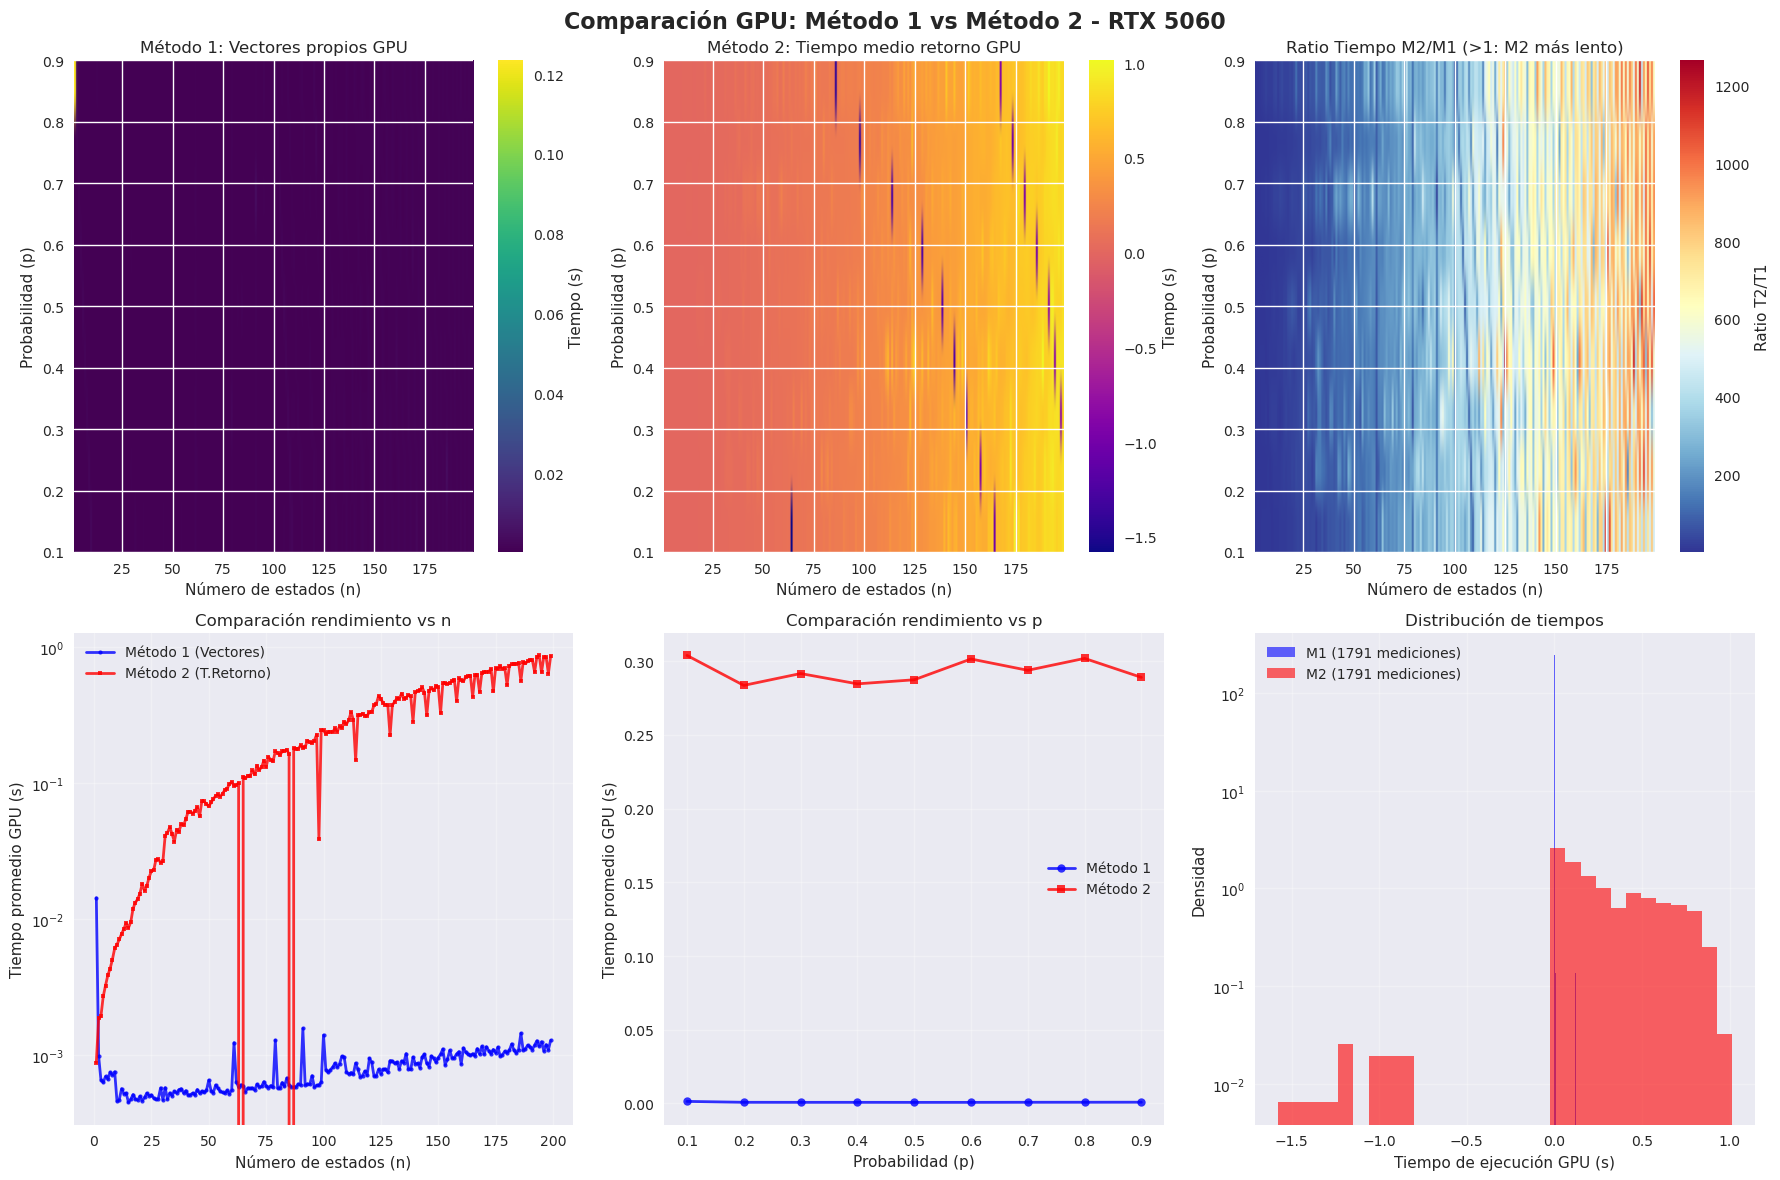

In [ ]:
# Visualización comparativa de ambos métodos
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Comparación GPU: Método 1 vs Método 2 - RTX 5060', fontsize=16, fontweight='bold')

# Preparar datos de visualización
matriz_viz_m1 = matriz_tiempos_metodo1.copy()
matriz_viz_m1[np.isnan(matriz_viz_m1)] = np.nanmax(matriz_viz_m1) if len(tiempos_validos_m1) > 0 else 0

matriz_viz_m2 = matriz_tiempos_metodo2.copy()
matriz_viz_m2[np.isnan(matriz_viz_m2)] = np.nanmax(matriz_viz_m2) if len(tiempos_validos_m2) > 0 else 0

# Fila 1: Heatmaps
# Heatmap Método 1
im1 = axes[0,0].imshow(matriz_viz_m1, aspect='auto', cmap='viridis', 
                       extent=[grid_n[0], grid_n[-1], grid_p[0], grid_p[-1]])
axes[0,0].set_xlabel('Número de estados (n)')
axes[0,0].set_ylabel('Probabilidad (p)')
axes[0,0].set_title('Método 1: Vectores propios GPU')
plt.colorbar(im1, ax=axes[0,0], label='Tiempo (s)')

# Heatmap Método 2
im2 = axes[0,1].imshow(matriz_viz_m2, aspect='auto', cmap='plasma', 
                       extent=[grid_n[0], grid_n[-1], grid_p[0], grid_p[-1]])
axes[0,1].set_xlabel('Número de estados (n)')
axes[0,1].set_ylabel('Probabilidad (p)')
axes[0,1].set_title('Método 2: Tiempo medio retorno GPU')
plt.colorbar(im2, ax=axes[0,1], label='Tiempo (s)')

# Comparación directa (ratio M2/M1)
if len(tiempos_validos_m1) > 0 and len(tiempos_validos_m2) > 0:
    ratio_matrix = np.where((matriz_tiempos_metodo1 > 0) & (matriz_tiempos_metodo2 > 0), 
                           matriz_tiempos_metodo2 / matriz_tiempos_metodo1, np.nan)
    ratio_viz = ratio_matrix.copy()
    ratio_viz[np.isnan(ratio_viz)] = np.nanmedian(ratio_viz)
    
    im3 = axes[0,2].imshow(ratio_viz, aspect='auto', cmap='RdYlBu_r', 
                           extent=[grid_n[0], grid_n[-1], grid_p[0], grid_p[-1]])
    axes[0,2].set_xlabel('Número de estados (n)')
    axes[0,2].set_ylabel('Probabilidad (p)')
    axes[0,2].set_title('Ratio Tiempo M2/M1 (>1: M2 más lento)')
    plt.colorbar(im3, ax=axes[0,2], label='Ratio T2/T1')
else:
    axes[0,2].text(0.5, 0.5, 'Datos insuficientes\npara comparación', 
                   ha='center', va='center', transform=axes[0,2].transAxes)
    axes[0,2].set_title('Comparación M2/M1')

# Fila 2: Análisis de rendimiento
# Tiempo promedio vs n para ambos métodos
if len(tiempos_validos_m1) > 0:
    tiempos_promedio_n_m1 = np.nanmean(matriz_tiempos_metodo1, axis=0)
    indices_validos_m1 = ~np.isnan(tiempos_promedio_n_m1)
    axes[1,0].plot(grid_n[indices_validos_m1], tiempos_promedio_n_m1[indices_validos_m1], 
                   'b-o', linewidth=2, markersize=3, label='Método 1 (Vectores)', alpha=0.8)

if len(tiempos_validos_m2) > 0:
    tiempos_promedio_n_m2 = np.nanmean(matriz_tiempos_metodo2, axis=0)
    indices_validos_m2 = ~np.isnan(tiempos_promedio_n_m2)
    axes[1,0].plot(grid_n[indices_validos_m2], tiempos_promedio_n_m2[indices_validos_m2], 
                   'r-s', linewidth=2, markersize=3, label='Método 2 (T.Retorno)', alpha=0.8)

axes[1,0].set_xlabel('Número de estados (n)')
axes[1,0].set_ylabel('Tiempo promedio GPU (s)')
axes[1,0].set_title('Comparación rendimiento vs n')
axes[1,0].set_yscale('log')
axes[1,0].grid(True, alpha=0.3)
axes[1,0].legend()

# Tiempo promedio vs p para ambos métodos
if len(tiempos_validos_m1) > 0:
    tiempos_promedio_p_m1 = np.nanmean(matriz_tiempos_metodo1, axis=1)
    axes[1,1].plot(grid_p, tiempos_promedio_p_m1, 'b-o', linewidth=2, 
                   markersize=6, label='Método 1', alpha=0.8)

if len(tiempos_validos_m2) > 0:
    tiempos_promedio_p_m2 = np.nanmean(matriz_tiempos_metodo2, axis=1)
    axes[1,1].plot(grid_p, tiempos_promedio_p_m2, 'r-s', linewidth=2, 
                   markersize=6, label='Método 2', alpha=0.8)

axes[1,1].set_xlabel('Probabilidad (p)')
axes[1,1].set_ylabel('Tiempo promedio GPU (s)')
axes[1,1].set_title('Comparación rendimiento vs p')
axes[1,1].grid(True, alpha=0.3)
axes[1,1].legend()

# Distribución conjunta de tiempos
if len(tiempos_validos_m1) > 0:
    axes[1,2].hist(tiempos_validos_m1, bins=30, alpha=0.6, color='blue', 
                   label=f'M1 ({len(tiempos_validos_m1)} mediciones)', density=True)
if len(tiempos_validos_m2) > 0:
    axes[1,2].hist(tiempos_validos_m2, bins=30, alpha=0.6, color='red', 
                   label=f'M2 ({len(tiempos_validos_m2)} mediciones)', density=True)

axes[1,2].set_xlabel('Tiempo de ejecución GPU (s)')
axes[1,2].set_ylabel('Densidad')
axes[1,2].set_title('Distribución de tiempos')
axes[1,2].set_yscale('log')
axes[1,2].grid(True, alpha=0.3)
axes[1,2].legend()

plt.tight_layout()
plt.show()

## Estadísticas Finales - Comparación Completa GPU

In [ ]:
# Estadísticas detalladas y comparación final
print("📊 ANÁLISIS FINAL: GPU DUAL METHOD BENCHMARK")
print("=" * 60)

# Información general
print(f"\n🔍 Configuración del análisis:")
print(f"• GPU: {gpu_info['name']}")
print(f"• Memoria GPU: {gpu_info['total_memory_mb']} MB")
print(f"• CUDA Version: {gpu_info['cuda_version']}")
print(f"• Combinaciones por método: {total_combinaciones:,}")
print(f"• Tiempo total de análisis: {tiempo_total/60:.1f} minutos")

# Estadísticas detalladas por método
print(f"\n⏱️ ESTADÍSTICAS DETALLADAS POR MÉTODO:")
print(f"{'='*80}")

methods_data = [
    ("MÉTODO 1 - Vectores propios", matriz_tiempos_metodo1, tiempos_validos_m1, tiempo_metodo1),
    ("MÉTODO 2 - Tiempo de retorno", matriz_tiempos_metodo2, tiempos_validos_m2, tiempo_metodo2)
]

for method_name, matriz, tiempos_validos, tiempo_ejecucion in methods_data:
    print(f"\n🔬 {method_name}:")
    print(f"   • Tiempo ejecución: {tiempo_ejecucion/60:.1f} minutos")
    print(f"   • Mediciones exitosas: {len(tiempos_validos):,}/{total_combinaciones:,} ({len(tiempos_validos)/total_combinaciones*100:.1f}%)")
    
    if len(tiempos_validos) > 0:
        print(f"   • Tiempo mínimo: {np.min(tiempos_validos):.6f} s")
        print(f"   • Tiempo máximo: {np.max(tiempos_validos):.6f} s")
        print(f"   • Tiempo promedio: {np.mean(tiempos_validos):.6f} s")
        print(f"   • Mediana: {np.median(tiempos_validos):.6f} s")
        print(f"   • Desv. estándar: {np.std(tiempos_validos):.6f} s")
        print(f"   • Throughput: {len(tiempos_validos)/tiempo_ejecucion:.1f} cálculos/segundo")
        
        # Análisis por rangos de n
        print(f"   • Análisis por rangos:")
        rangos_n = [(1, 100), (101, 300), (301, 600), (601, 999)]
        for n_min, n_max in rangos_n:
            mask_n = (grid_n >= n_min) & (grid_n <= n_max)
            if np.any(mask_n):
                tiempos_rango = matriz[:, mask_n]
                tiempos_rango_validos = tiempos_rango[~np.isnan(tiempos_rango)]
                if len(tiempos_rango_validos) > 0:
                    print(f"     - n={n_min:3d}-{n_max:3d}: {np.mean(tiempos_rango_validos):.5f}s promedio ({len(tiempos_rango_validos):,} datos)")

# Comparación directa de métodos
if len(tiempos_validos_m1) > 0 and len(tiempos_validos_m2) > 0:
    print(f"\n⚔️ COMPARACIÓN DIRECTA:")
    print(f"{'='*50}")
    
    speedup = np.mean(tiempos_validos_m2) / np.mean(tiempos_validos_m1)
    throughput_m1 = len(tiempos_validos_m1) / tiempo_metodo1
    throughput_m2 = len(tiempos_validos_m2) / tiempo_metodo2
    
    print(f"• Speedup M1 vs M2: {speedup:.2f}x")
    print(f"• Throughput M1: {throughput_m1:.1f} cálculos/s")
    print(f"• Throughput M2: {throughput_m2:.1f} cálculos/s")
    print(f"• Método más rápido: {'Método 1 (Vectores)' if speedup > 1 else 'Método 2 (T.Retorno)'}")
    
    # Análisis de correlación
    # Buscar puntos comunes válidos para comparar
    puntos_comunes = (~np.isnan(matriz_tiempos_metodo1)) & (~np.isnan(matriz_tiempos_metodo2))
    if np.any(puntos_comunes):
        t1_comun = matriz_tiempos_metodo1[puntos_comunes]
        t2_comun = matriz_tiempos_metodo2[puntos_comunes]
        correlacion = np.corrcoef(t1_comun, t2_comun)[0,1]
        print(f"• Correlación de tiempos: {correlacion:.3f}")
        print(f"• Puntos comparables: {np.sum(puntos_comunes):,}")

# Información final de GPU
gpu_info_final = get_gpu_info()
print(f"\n💻 ESTADO FINAL DE GPU:")
print(f"• Memoria libre: {gpu_info_final['free_memory_mb']} MB")
print(f"• Memoria usada: {gpu_info_final['used_memory_mb']} MB")
print(f"• Eficiencia memoria: {(gpu_info_final['total_memory_mb'] - gpu_info_final['free_memory_mb'])/gpu_info_final['total_memory_mb']*100:.1f}% utilizada")

print(f"\n📁 ARCHIVOS GENERADOS:")
print(f"• {archivo_metodo1}")
print(f"• {archivo_metodo2}")

print(f"\n🎉 BENCHMARK DUAL METHOD COMPLETADO!")
print(f"⚡ RTX 5060 procesó {len(tiempos_validos_m1) + len(tiempos_validos_m2):,} cálculos totales")
print(f"📊 Datos listos para análisis comparativo avanzado")

# Limpiar memoria GPU final
clear_gpu_memory()
print(f"🧹 Memoria GPU completamente limpiada")

📊 ANÁLISIS FINAL: GPU DUAL METHOD BENCHMARK

🔍 Configuración del análisis:
• GPU: NVIDIA GeForce RTX 5060 Laptop GPU
• Memoria GPU: 8150 MB
• CUDA Version: 13000
• Combinaciones por método: 1,791
• Tiempo total de análisis: 8.8 minutos

⏱️ ESTADÍSTICAS DETALLADAS POR MÉTODO:

🔬 MÉTODO 1 - Vectores propios:
   • Tiempo ejecución: 0.0 minutos
   • Mediciones exitosas: 1,791/1,791 (100.0%)
   • Tiempo mínimo: 0.000274 s
   • Tiempo máximo: 0.123443 s
   • Tiempo promedio: 0.000843 s
   • Mediana: 0.000656 s
   • Desv. estándar: 0.002922 s
   • Throughput: 1094.2 cálculos/segundo
   • Análisis por rangos:
     - n=  1-100: 0.00073s promedio (900 datos)
     - n=101-300: 0.00095s promedio (891 datos)

🔬 MÉTODO 2 - Tiempo de retorno:
   • Tiempo ejecución: 8.7 minutos
   • Mediciones exitosas: 1,791/1,791 (100.0%)
   • Tiempo mínimo: -1.580103 s
   • Tiempo máximo: 1.014153 s
   • Tiempo promedio: 0.292996 s
   • Mediana: 0.225979 s
   • Desv. estándar: 0.297011 s
   • Throughput: 3.4 cálcul